In [27]:
import numpy 
import pandas
import cobra
import scipy, scipy.signal
from pathlib import Path
from cobra.io import load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model, load_model, to_json
import logging
import time 
import os
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.family':'sans-serif',
                            'font.size':20, 
                            'xtick.labelsize':30, 
                            'ytick.labelsize':30, 
                            'figure.figsize':(20, 10), 
                            'axes.labelsize':40})

import seaborn
import pingouin 
import scipy, scipy.stats
from scipy.stats import ttest_ind
import statsmodels, statsmodels.stats, statsmodels.stats.multitest
import cobamp
import docplex
import gseapy
import peat
import bioservices
import keggtools
from bioservices import KEGG
from keggtools import Resolver
import gseapy
import escher
import scipy.io
import json
from escher import Builder, rc
from cobra import Model, Reaction, Metabolite
from sklearn.decomposition import PCA

data_dir = Path(".") / ".." / "src" / "cobra" / "data"
data_dir = data_dir.resolve()

## 1. Generate fluxes for 100 points on an Ecoli.core Model with decreasing oxygen

In [43]:
model = load_model('textbook')

In [44]:
model

Name,e_coli_core
Memory address,0x07f8a58b76280
Number of metabolites,72
Number of reactions,95
Number of groups,0
Objective expression,1.0*Biomass_Ecoli_core - 1.0*Biomass_Ecoli_core_reverse_2cdba
Compartments,"cytosol, extracellular"


In [45]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,4.765,0,0.00%
o2_e,EX_o2_e,21.8,0,0.00%
pi_e,EX_pi_e,3.215,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-22.81,1,100.00%
h2o_e,EX_h2o_e,-29.18,0,0.00%
h_e,EX_h_e,-17.53,0,0.00%


In [46]:
solution = model.optimize()
solution.objective_value

0.8739215069684304

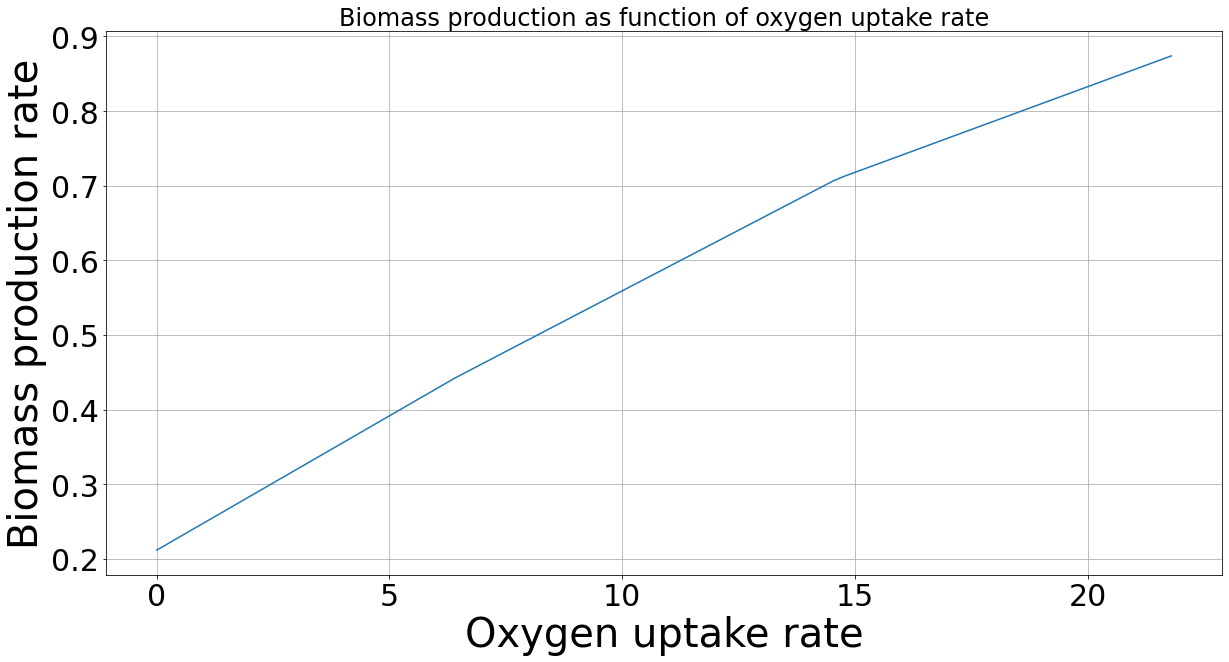

In [48]:
# higher_boundary
# model is exploring 21.8 units of o2
# Explore 100 points from 0 to 21.8 
# Then see impact of biomass
# x see impact of biomass
# do FBA and "pFBA"
# 
oxygen_fluxes = numpy.linspace(0, 21.8, 100)  

resulting_fluxes = []

for flux in oxygen_fluxes:
    model.reactions.EX_o2_e.lower_bound = -flux  # Notice the negative sign, uptake reactions are typically negative in cobra models
    solution = model.optimize()
    if solution.status == 'optimal':
        resulting_fluxes.append(solution.objective_value)
    else:
        resulting_fluxes.append(numpy.nan)

matplotlib.pyplot.figure(figsize = (20, 10))
matplotlib.pyplot.plot(oxygen_fluxes, resulting_fluxes)  # Switched the axes
matplotlib.pyplot.xlabel('Oxygen uptake rate')
matplotlib.pyplot.ylabel('Biomass production rate')
matplotlib.pyplot.title('Biomass production as function of oxygen uptake rate')
matplotlib.pyplot.grid(True)
matplotlib.pyplot.show()


In [47]:
oxygen_fluxes

array([-1000.        ,  -989.8989899 ,  -979.7979798 ,  -969.6969697 ,
        -959.5959596 ,  -949.49494949,  -939.39393939,  -929.29292929,
        -919.19191919,  -909.09090909,  -898.98989899,  -888.88888889,
        -878.78787879,  -868.68686869,  -858.58585859,  -848.48484848,
        -838.38383838,  -828.28282828,  -818.18181818,  -808.08080808,
        -797.97979798,  -787.87878788,  -777.77777778,  -767.67676768,
        -757.57575758,  -747.47474747,  -737.37373737,  -727.27272727,
        -717.17171717,  -707.07070707,  -696.96969697,  -686.86868687,
        -676.76767677,  -666.66666667,  -656.56565657,  -646.46464646,
        -636.36363636,  -626.26262626,  -616.16161616,  -606.06060606,
        -595.95959596,  -585.85858586,  -575.75757576,  -565.65656566,
        -555.55555556,  -545.45454545,  -535.35353535,  -525.25252525,
        -515.15151515,  -505.05050505,  -494.94949495,  -484.84848485,
        -474.74747475,  -464.64646465,  -454.54545455,  -444.44444444,
      

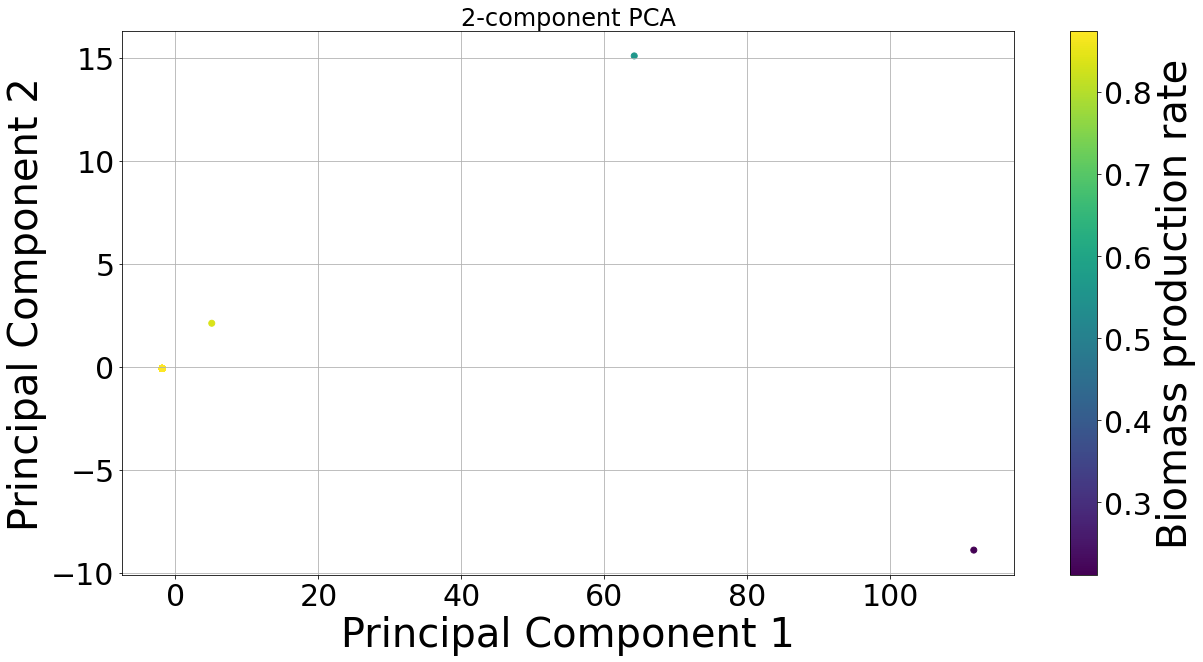

In [38]:
all_fluxes = []

for flux in oxygen_fluxes:
    model.reactions.EX_o2_e.lower_bound = flux
    solution = model.optimize()
    if solution.status == 'optimal':
        all_fluxes.append(solution.fluxes)
    else:
        all_fluxes.append([numpy.nan] * len(model.reactions))

df = pandas.DataFrame(all_fluxes, columns = [r.id for r in model.reactions])

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(df.fillna(0))  # fill NaN values with 0
principalDf = pandas.DataFrame(data = principalComponents, columns = ['principal component 1', 
                                                                      'principal component 2'])

principalDf['Biomass production rate'] = resulting_fluxes

fig, ax = matplotlib.pyplot.subplots(figsize = (20, 10))
scatter = ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'],
                     c = principalDf['Biomass production rate'], cmap = 'viridis')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('2-component PCA')
fig.colorbar(scatter, ax = ax, label = 'Biomass production rate')
ax.grid(True)
matplotlib.pyplot.show()